# Introduction





In [32]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from textwrap import wrap

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [42]:
dam_levels = pd.read_csv('data/processed/Dam-levels-clean-20120101-20171206.csv', encoding = 'latin1')
dam_levels['date'] = pd.to_datetime(dam_levels['date'])

# Add some date-related fields that will be useful later
dam_levels['year'] = dam_levels['date'].dt.year
dam_levels['month'] = dam_levels['date'].dt.month
dam_levels['monthname'] = dam_levels['date'].dt.strftime('%b')
dam_levels['dayofmonth'] = dam_levels['date'].dt.day
dam_levels['daymonthyear'] = dam_levels['dayofmonth'].apply(str) + '-' + dam_levels['monthname'] + '-' + dam_levels['year'].apply(str)

# In the plot that follows, we'll want to be smart about how we label the x-axis. Too many labels will make it 
# unreadable but having too few will make it more difficult to see what date period we're looking at. 
# Generally we'll want to plot the 1st date of every month at a particular interval. We need to calculate an 
# associated index, which will tell the plotting library where to place the labels - that's what the `dayofyear` 
# and `cumsum_dayofyear` columns are doing in the dataframe below.
first_day_of_month = dam_levels.loc[(dam_levels['dayofmonth'] == 1), ['date', 'month', 'daymonthyear']].drop_duplicates()
first_day_of_month['lag_date'] = first_day_of_month['date'].shift(periods = 1)
first_day_of_month['cumsum_dayofyear'] = (first_day_of_month['date'] - first_day_of_month['lag_date']).dt.days.cumsum().fillna(0) + 1

# Create a pivot table so that we have the storage for each dam in the columns and each day is a different row
storage_ml_pivot = dam_levels.pivot_table(index = 'date', columns = 'dam_name', values = 'storage_ml')
# Sum the storage for all dams
agg_storage_ml = storage_ml_pivot.apply(np.sum, axis = 1)
agg_storage_ml = pd.DataFrame({'storage_ml': agg_storage_ml})
agg_storage_ml['year'] = agg_storage_ml.index.year
agg_storage_ml = agg_storage_ml.reset_index()
agg_storage_ml.index = agg_storage_ml['date']

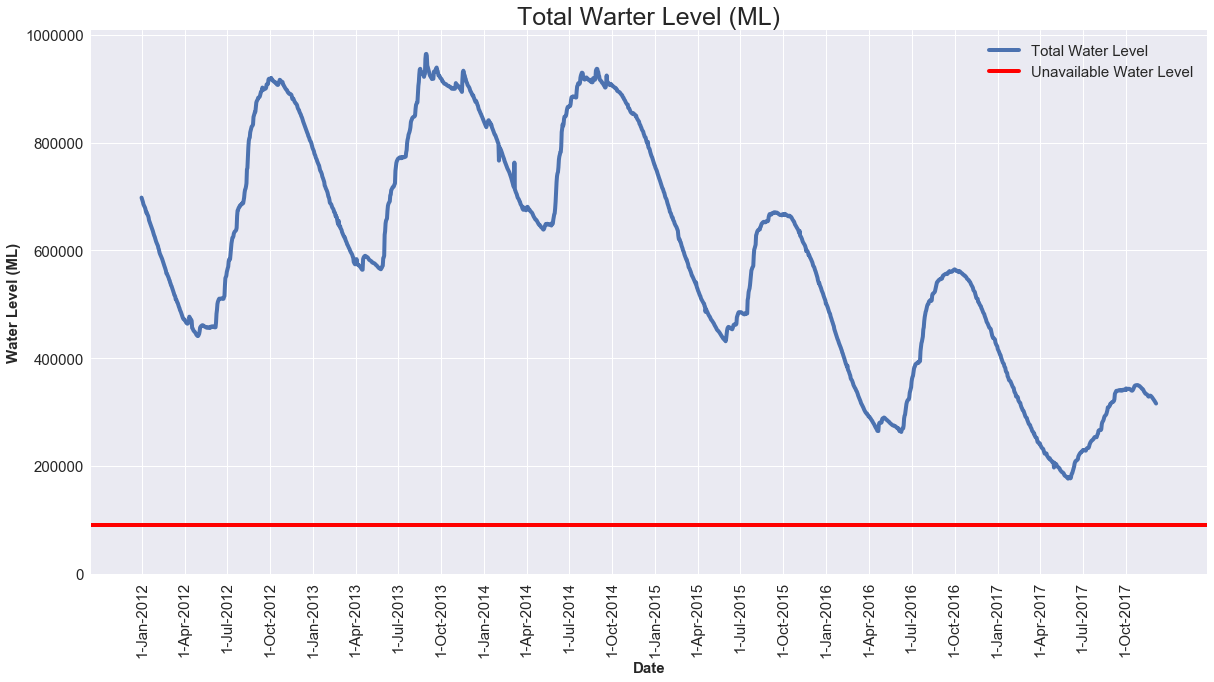

In [44]:
# Sets style for pyplot graphs to match seaborn
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=[20,10]) # [w, h]
plt.plot(range(len(agg_storage_ml)),
         agg_storage_ml['storage_ml'], 
         label = 'Total Water Level', 
         linewidth = 4)
ax.axhline(y = capacity.loc['total']['unavailable_storage_ml'], 
           label = 'Unavailable Water Level', 
           c = 'red', 
           linewidth = 4)

first_day_of_quarter = first_day_of_month[first_day_of_month['month'].isin([1, 4, 7, 10])]

plt.xticks(first_day_of_quarter['cumsum_dayofyear'], first_day_of_quarter['daymonthyear'], rotation = 90, fontsize = 15);
plt.xlabel('Date', fontsize = 15, fontweight = 'bold')

plt.yticks(fontsize = 15)
plt.ylabel('Water Level (ML)', fontsize = 15, fontweight = 'bold')
plt.ylim(ymin = 0)

plt.legend(fontsize = 15)
plt.title('Total Warter Level (ML)', fontsize = 25);

There are 4 sections to this notebook. Each addresses a different problem:
1. Provide my own estimate for when the city will run out of water.
2. Figure out what water level is needed going in to next summer so that we don't run out of water.
3. Estimate how long it would take for dams to be replenished during the next rainy season to reach the requisite level.
4. Determine what a 2-year 'sustainable' dam capacity is. In other words, how high do the dams need to be going into summer *next year* to obviate our running out of water in 2019 if that year sees another bad rainy season?


# 1. When will we run out of water?

There have been estimates for when the city will run out of water - notably from the [CSAG](http://www.csag.uct.ac.za/2017/10/24/waiting-for-the-rain/) and [this](http://www.howmanydaysofwaterdoescapetownhaveleft.co.za/) website. While the latter doesn't disclose how they arrived at their number, the former, written by [Piotr Wolski](http://www.csag.uct.ac.za/author/pwolski/) does. My approach will follow his logic. My contribution here will be in providing an updated figure, based on current dam levels and usage stats.

Let's assume that there are no meaningful inflows of water into the dams during the summer period. Then we can work out the number of days of water we have left with this simple formula:
$$d = {s \over c}$$

where:
+ d = number of days remaining
+ s = current volume of water storaged in the dams
+ c = average daily water consumption

The City of Cape Town (CoCT) published a ("water dashboard"](https://resource.capetown.gov.za/documentcentre/Documents/City%20research%20reports%20and%20review/damlevels.pdf), which states that the total volume of dammed water is 282,417Ml. However, the last 10% of the water is unusable, since it become impossible to extract. The total capacity is 902,598Ml, which means that we need to subtract 90,259.8Ml, which leaves us 192,157Ml remaining. 

The same source shows daily consumption by the City at 561Ml (Ml = "megalitres") per day. So we almost have everything we need to plug in to the above formula and solve for the days. However, we only have the *City's* consumption. According to the Water & Sanitation Department, CoCT's share of total water consumption is only 40%. This is illustrated in the chart below, which can be found [here](https://www.groundup.org.za/media/uploads/documents/BusinessBriefingOnWaterCrisis9MayPeterFlowerPresentationHandout.pdf):

<img src= resources/waterusewcwss.png style="width: 350px;"/>

So if we want to get the *total* water consumption, we need to scale up the the consumption by a factor of 100/40 = 2.5. This means that total consumtpion is 1402.5Ml per day. This means that we have 192,157/1,402.5 = 137 days left. This puts 'day zero' at 19 May 2018.

In [9]:
# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import datetime
(datetime.date.today() + datetime.timedelta(days = 137)).strftime('%Y-%m-%d')

'2018-05-23'

The table below shows the same for different consumption levels:

# 2. How much water do we need going in to summer?

How much water do we need in the dams at the beginning of summer to last us through the season, until the winter rains come? This depends on how much water we use. I will attempt to answer this question given historical, current, and target water usage levels.

If we again assume that there will be no meaningful inflows of water into the dam, we can can just rearrange the equation above and solve for *s* - the total storage needed is the sum of all the water consumed each day: 
$$s = d \times c$$

The water consumption per day is a parameter that we don't need to calculate. Eyeballing dam storage graph above, we can see that dam levels drop off from between the beginning of October and the latter half of June. Let's be conservative here, and assume that the dry season ends on the 15th of June. That gives us 287 days. This leaves only 20% of the year to for water levels to recover.

In [10]:
dry_season_end_date = datetime.datetime(year = 2019, month = 6, day = 15)
dry_season_start_date = datetime.datetime(year = 2018, month = 9, day = 1)
print('Days in the dry season:', (dry_season_end_date - dry_season_start_date).days)
print('Percent of days in the year that are within the dry season: ', ('{:.0%}').format(287/365))

Days in the dry season: 287
Percent of days in the year that are within the dry season:  79%


Plugging in to our equation above, we get s = 287 * 1,402.5 = 402,517.5. We can do the same for different consumption levels.

In [11]:
import pandas as pd
storage_needed = pd.DataFrame()
storage_needed['CoCT Avg Daily Consumption'] = [500, 561, 600]
storage_needed['Total Avg Daily Consumption'] = 2.5 * storage_needed['CoCT Avg Daily Consumption']
storage_needed['Storage Needed'] = 287 * storage_needed['Total Avg Daily Consumption']
storage_needed.style.format('{:,.0f}')

,CoCT Avg Daily Consumption,Total Avg Daily Consumption,Storage Needed
0,500,"1,250","358,750"
1,561,"1,402","402,518"
2,600,"1,500","430,500"


# 3. How long will it take for dam levels to reach sustainable levels?

So far, we have been working with the dry period and have not been worrying about inflows of water into the dams. However, the wet season brings rains, which will cause dam levels to increase. Generally, there are enough rains each year that we don't need to worry about running out by the end of the proceeding dry season. However, that is not a given. If we assume that we have no water left by the end of the current dry season, how long will it take to get back to a sustainable levels? 

I will assume that the daily average consumption remaines 561Ml so that a sustainable level is 402,518Ml. If we have usable water left by the end of summer this year, how long will it take us to get back to that level? There are different ways to model the dams but let's keep it simple for now and use a straight line. Taking the dam levels for the beginngina nd end of the rainy season each year, we can figure out the gradient of the line for each year. I will work out how long it will take, given 3 scenarios: (1) best case: using the steepest gradient, (2) average: using the average gradient, and (3) worst case: using the most lowest gradient.

To be conservative, I'm going to assume that the beginning of the wet season is the day after the the minimum dam level is reached for the year and the end of the wet season is the day the maximum dam storage is reached.



In [30]:
# min_storage = agg_storage_ml.loc[agg_storage_ml.loc[(agg_storage_ml['date'].dt.month == 6) &
#                                                     (agg_storage_ml['date'].dt.day == 1)].index, ['year', 'storage_ml']]
min_storage = agg_storage_ml.loc[agg_storage_ml.groupby('year')['storage_ml'].idxmin(), ['year', 'storage_ml']]
min_storage = min_storage.reset_index()[['year', 'date', 'storage_ml']]
min_storage = min_storage.rename(columns = {'date': 'start_date',
                                           'storage_ml': 'start_storage_ml'})

max_storage = pd.merge(agg_storage_ml, min_storage, on = ['year'])
max_storage.index = max_storage['date']
max_storage = max_storage.loc[max_storage['date'] > max_storage['start_date']]

max_storage = max_storage.loc[max_storage.groupby('year')['storage_ml'].idxmax(), ['year', 'storage_ml']]
max_storage = max_storage.reset_index()[['year', 'date', 'storage_ml']]
max_storage = max_storage.rename(columns = {'date': 'end_date',
                                           'storage_ml': 'end_storage_ml'})

wet_season = pd.merge(min_storage, max_storage, on = ['year'], copy = False)
wet_season = wet_season.rename(columns = {'date': 'start_date'})
wet_season['season_length'] = wet_season['end_date'] - wet_season['start_date']

wet_season_storage = pd.merge(agg_storage_ml, wet_season, on = ['year'])
wet_season_storage = wet_season_storage[(wet_season_storage['date'] >= wet_season_storage['start_date']) &
                       (wet_season_storage['date'] <= wet_season_storage['end_date'])]

In [16]:
aligned_wet_seasons = {}
flat_wet_seasons = pd.DataFrame()
for y in list(range(2012,2018)):
    season = pd.DataFrame()
    season['date'] = wet_season_storage.loc[wet_season_storage['year'] == y, 'date']
    season['season_day'] = list(range(len(season['date'])))
    season['storage_ml'] = (wet_season_storage.loc[wet_season_storage['year'] == y, 'storage_ml'] - wet_season_storage.loc[wet_season_storage['year'] == y, 'start_storage_ml']).tolist()
    aligned_wet_seasons[y] = season
    flat_wet_seasons = pd.concat([flat_wet_seasons, season], axis = 0)
    
f = np.polyfit(flat_wet_seasons['season_day'], flat_wet_seasons['storage_ml'], deg = 3)
all_fit = np.poly1d(f)

flat_wet_seasons_good = flat_wet_seasons[flat_wet_seasons['date'].dt.year.isin([2012, 2013])]
f = np.polyfit(flat_wet_seasons_good['season_day'], flat_wet_seasons_good['storage_ml'], deg = 3)
good_season_fit = np.poly1d(f)

flat_wet_seasons_bad = flat_wet_seasons[flat_wet_seasons['date'].dt.year.isin([2014, 2015, 2016])]
f = np.polyfit(flat_wet_seasons_bad['season_day'], flat_wet_seasons_bad['storage_ml'], deg = 3)
bad_season_fit = np.poly1d(f)

flat_wet_seasons_worst = flat_wet_seasons[flat_wet_seasons['date'].dt.year.isin([2017])]
f = np.polyfit(flat_wet_seasons_worst['season_day'], flat_wet_seasons_worst['storage_ml'], deg = 3)
worst_season_fit = np.poly1d(f)

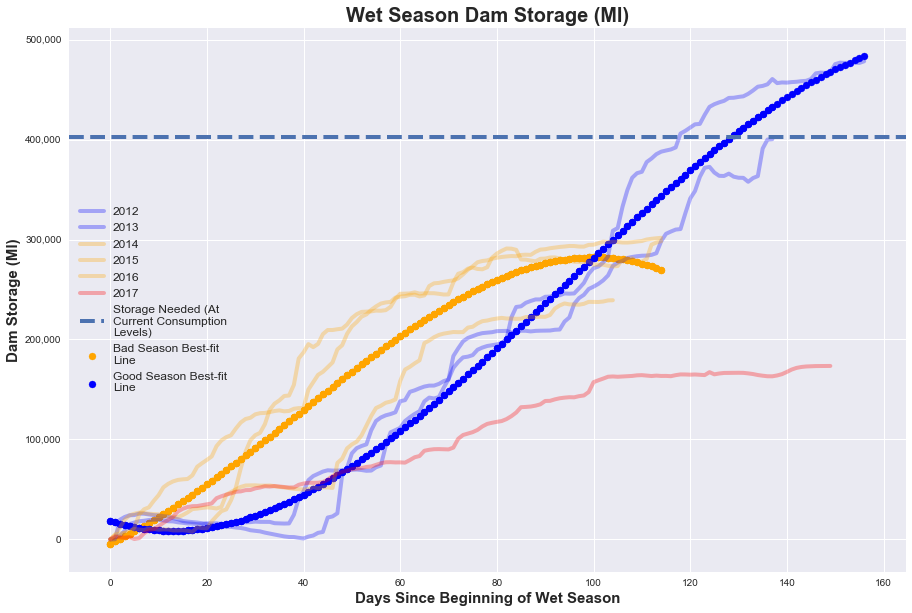

In [17]:

fig, ax = plt.subplots(figsize=(15,10))
colours = [
    'blue',
    'blue',
    'orange',
    'orange',
    'orange',
    'red',
]

y = list(range(2012,2018))
# y = [2012,2013,2015,2016]
for i, y in enumerate(y):
    plt.plot(aligned_wet_seasons[y]['season_day'], aligned_wet_seasons[y]['storage_ml'], label = y, 
             c = colours[i], linewidth = 4, alpha = 0.3)
ax.axhline(402518, linewidth = 4, label = 'Storage Needed (At Current Consumption Levels)', linestyle = '--')
# plt.scatter(flat_wet_seasons['season_day'], all_fit(flat_wet_seasons['season_day']), 
#             c = 'green', label = 'Total Best-fit Line')
plt.scatter(flat_wet_seasons_bad['season_day'], bad_season_fit(flat_wet_seasons_bad['season_day']), 
            c = 'orange', label = 'Bad Season Best-fit Line')
# plt.scatter(flat_wet_seasons_worst['season_day'], worst_season_fit(flat_wet_seasons_worst['season_day']), 
#             c = 'red', label = 'Worst Season Best-fit Line')
plt.scatter(flat_wet_seasons_good['season_day'], good_season_fit(flat_wet_seasons_good['season_day']), 
            c = 'blue', label = 'Good Season Best-fit Line')

plt.title('Wet Season Dam Storage (Ml)', fontsize = 20, fontweight = 'bold')
plt.xlabel('Days Since Beginning of Wet Season', fontsize = 15, fontweight = 'bold', )
plt.ylabel('Dam Storage (Ml)', fontsize = 15, fontweight = 'bold')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

handles, labels = ax.get_legend_handles_labels()
labels = [ '\n'.join(wrap(lab, 20)) for lab in labels]
ax.legend(labels, fontsize = 12)

plt.show();

# 3. What dam storage is sustainable at the beginning of summer?
By *sustainable* dam storage, I mean that we have enough water to last us, not only through the impending summer season, but, in combination with water production in winter, the *following* season. By *water production*, I mean addional water storage added to the dams - whether by precipitation or other means, such as desalination. Why could this be different from the question that I answered above, regarding how much water we need going in to summer? If the net water production (water production less water usage) during the winter season does not at least equal the amount we use during summer, then we need some water left in the dam after summer is over to make the difference. We have seen from the above analysis that it is possible to go from zero water to having enough (based on current consumption, which takes into account strict rationing) to last the following winter. I don't call this sustainable because we don't know what is going to happen in the future and to be so dependent on one good season is probably not a good strategy. A different way of formulating this question is, how much water do we need such that *if we have a bad winter, we don't run out of water*. This will depend on water usage throughout winter, as well as how much water finds it's way into the system throughout the period. 

If we assume that we need at 402,518Ml in the dam at the beginning of the 2019 dry season, we can think through good and bad weather scenarios for next year's wet season to figure out how much we would need at the end of the 2018 wet season. We can see from the last section that the most water we can hope for in a bad season is 301696ML and 478366Ml in a good one. If there is a good season next year, then, we won't run out of water even if we ran out of water this year and resorted to having to buy in water. However, in the bad scenario ,we would need about 100822Ml, which means that we would need 503340 left at the end of this year's rainy season. Even in a good year, we wouldn't get that much rain in one season (we would be about 25000Ml short). So to have a sustainable amount of water for a 2-year period, we would still need to likely top-up or ratio water.

In [26]:
flat_wet_seasons_bad.max()
flat_wet_seasons_good.max()

date          2016-10-02 00:00:00
season_day                    114
storage_ml                 301696
dtype: object

date          2013-08-31 00:00:00
season_day                    156
storage_ml                 478366
dtype: object

# Conclusion